# deepBreaks applications
## Predicting the subtype of the HIV-1 virus based on its V3 amino-acid sequence   
PLACEHOLDER FOR DESCRIPTION
<p style="text-align:center;">
<figure>
  <img src="../img/HIV/v3.png" alt="V3" style="width: 400px;">
    <figcaption>Image from: <a size=10 href=https://doi.org/10.1371/journal.pcbi.0030058>Sander, Oliver, et al. "Structural descriptors of gp120 V3 loop for the prediction of HIV-1 coreceptor usage." PLoS computational biology 3.3 (2007): e58.</a> 
        </figcaption>
</figure>
</p>

In [1]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/HIV/HIV-1_env.fasta'

# name of the phenotype
mt = 'subtype'

# type of the sequences
seq_type = 'amino-acid'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)

positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading fasta file
Done
Shape of data is:  (5000, 1088)
CPU times: user 1.55 s, sys: 53.4 ms, total: 1.6 s
Wall time: 1.61 s


In [6]:
import pandas as pd

# our meta-data are the subtypes of the virus and the first 
# character of the names of the sequences are the labels 'A' and 'C'.
metaData = pd.DataFrame(data=df.index.str[0], index=df.index, columns=['subtype'])

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [7]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


,subtype
A.SE.2002.SE_P70.24411.EU010268,A
A.SE.2001.SE_P57.22867.EU010267,A
A.SE.2001.SE_P57.22661.EU010266,A
A.SE.2000.SE_P35.21525.EU010265,A
A.GA.2004.OYE080.AM903390,A


In [8]:
print('sequence data looks like this:')
df.head()

sequence data looks like this:


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p1079,p1080,p1081,p1082,p1083,p1084,p1085,p1086,p1087,p1088
A.SE.2002.SE_P70.24411.EU010268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
A.SE.2001.SE_P57.22867.EU010267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
A.SE.2001.SE_P57.22661.EU010266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
A.SE.2000.SE_P35.21525.EU010265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
A.GA.2004.OYE080.AM903390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


In [9]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [10]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (5000, 1088)
Shape of data after missing/constant care:  (5000, 35)
CPU times: user 639 ms, sys: 6.3 ms, total: 645 ms
Wall time: 647 ms


In [11]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (5000, 35)
Shape of data after imbalanced care:  (5000, 17)
CPU times: user 149 ms, sys: 3.15 ms, total: 152 ms
Wall time: 150 ms


In [12]:
df.head()

,p433,p436,p443,p444,p445,p446,p450,p458,p460,p462,p463,p464,p465,p466,p468,p473,p475
A.SE.2002.SE_P70.24411.EU010268,T,N,E,S,I,R,I,T,Y,T,G,D,V,I,D,Q,Y
A.SE.2001.SE_P57.22867.EU010267,T,G,T,S,I,R,I,T,Y,T,G,D,V,I,D,K,H
A.SE.2001.SE_P57.22661.EU010266,T,G,T,S,I,R,I,T,Y,T,G,D,V,I,D,K,H
A.SE.2000.SE_P35.21525.EU010265,I,G,T,S,I,R,I,T,Y,T,G,D,V,I,D,K,Y
A.GA.2004.OYE080.AM903390,T,N,K,S,I,R,I,VSMIPNEL,Y,ARSNMIHPQEGKVL,G,NSQKRVTPH,I,I,N,Q,H


In [13]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  17
number of columns of main data after:  17
CPU times: user 123 ms, sys: 5.22 ms, total: 128 ms
Wall time: 130 ms


In [14]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)

one-hot encoding the dataset
CPU times: user 34.1 ms, sys: 2.23 ms, total: 36.3 ms
Wall time: 34.7 ms


In [15]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(30, 30)
CPU times: user 14.4 ms, sys: 3.3 ms, total: 17.7 ms
Wall time: 17.2 ms


In [16]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


,p433_SVAMERLYNFKCQD,p433_T,p436_N,p436_S,p443_K,p443_QSNAIDGHP,p443_R,p443_T,p444_S,p445_M,...,p464_D,p464_E,p464_G,p464_NSQKRVTPH,p465_V,p466_TVMLKSANRYG,p468_N,p473_K,p473_Q,p475_Y
p433_SVAMERLYNFKCQD,0.000000,0.430799,0.896912,0.976795,0.946225,0.955517,0.978202,0.948385,0.995830,0.981261,...,0.947631,0.937443,0.947450,0.934539,0.954007,0.959072,0.981619,0.951985,0.910647,0.900624
p433_T,0.430799,0.000000,0.853241,0.966187,0.892663,0.957423,0.946991,0.941814,0.985065,0.953912,...,0.904948,0.927263,0.986467,0.913663,0.949320,0.967357,0.997210,0.935443,0.938143,0.932590
p436_N,0.896912,0.853241,0.000000,0.621909,0.975089,0.982248,0.961851,0.977907,0.894852,0.890459,...,0.992140,0.956188,0.914253,0.951657,0.874345,0.922063,0.939157,0.995998,0.971925,0.891682
p436_S,0.976795,0.966187,0.621909,0.000000,0.962592,0.974194,0.996279,0.972600,0.982068,0.994242,...,0.949966,0.928955,0.984492,0.958761,0.933738,0.860918,0.970303,0.962187,0.935117,0.936910
p443_K,0.946225,0.892663,0.975089,0.962592,0.000000,0.651082,0.431755,0.558261,0.967325,0.954239,...,0.957956,0.935728,0.927026,0.899250,0.919594,0.938438,0.925510,0.910295,0.939159,0.944978


In [17]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.2,
                       needs_pivot=False)

finding colinear groups
CPU times: user 74.1 ms, sys: 32.1 ms, total: 106 ms
Wall time: 203 ms


In [18]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


,feature,group
11,p446_H,g0
12,p446_R,g0


Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [19]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)

grouping features
CPU times: user 13 ms, sys: 3.07 ms, total: 16.1 ms
Wall time: 14.3 ms


In [20]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)

dropping correlated features
Shape of data before collinearity care:  (5000, 30)
Shape of data after collinearity care:  (5000, 29)


In [21]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [22]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

,Description,Value
0,session_id,123
1,Target,subtype
2,Target Type,Binary
3,Label Encoded,"A: 0, C: 1"
4,Original Data,"(5000, 30)"
5,Missing Values,False
6,Numeric Features,29
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


CPU times: user 6.23 s, sys: 1.86 s, total: 8.1 s
Wall time: 9.62 s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

/Users/mbagh/Documents/RahLab/deepBreaks_data/HIV/HIV-1_env_subtype_2022-11-04_14-14-15/Random Forest Classifier_350.png
Random Forest Classifier  Done
/Users/mbagh/Documents/RahLab/deepBreaks_data/HIV/HIV-1_env_subtype_2022-11-04_14-14-15/Light Gradient Boosting Machine_350.png
Light Gradient Boosting Machine  Done
/Users/mbagh/Documents/RahLab/deepBreaks_data/HIV/HIV-1_env_subtype_2022-11-04_14-14-15/Extreme Gradient Boosting_350.png
Extreme Gradient Boosting  Done


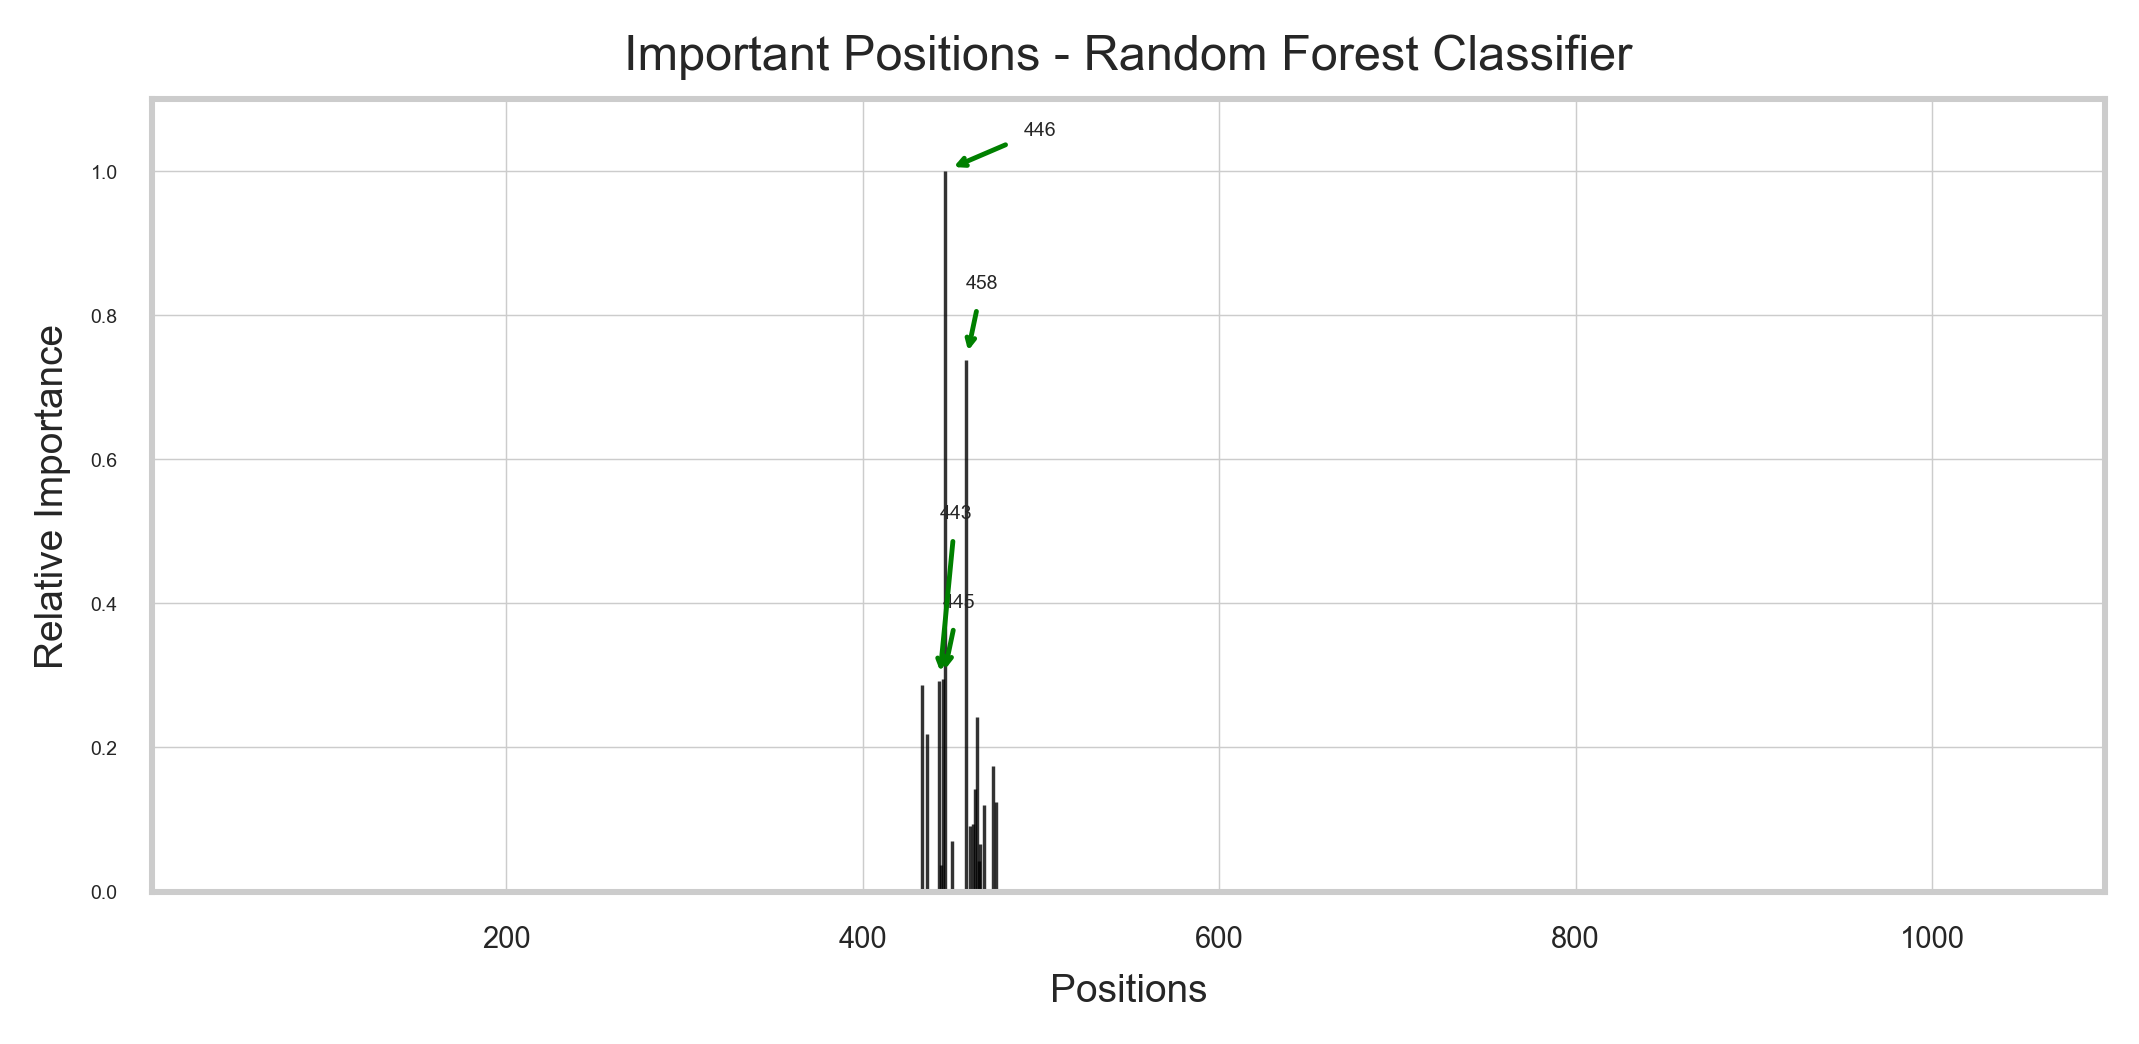

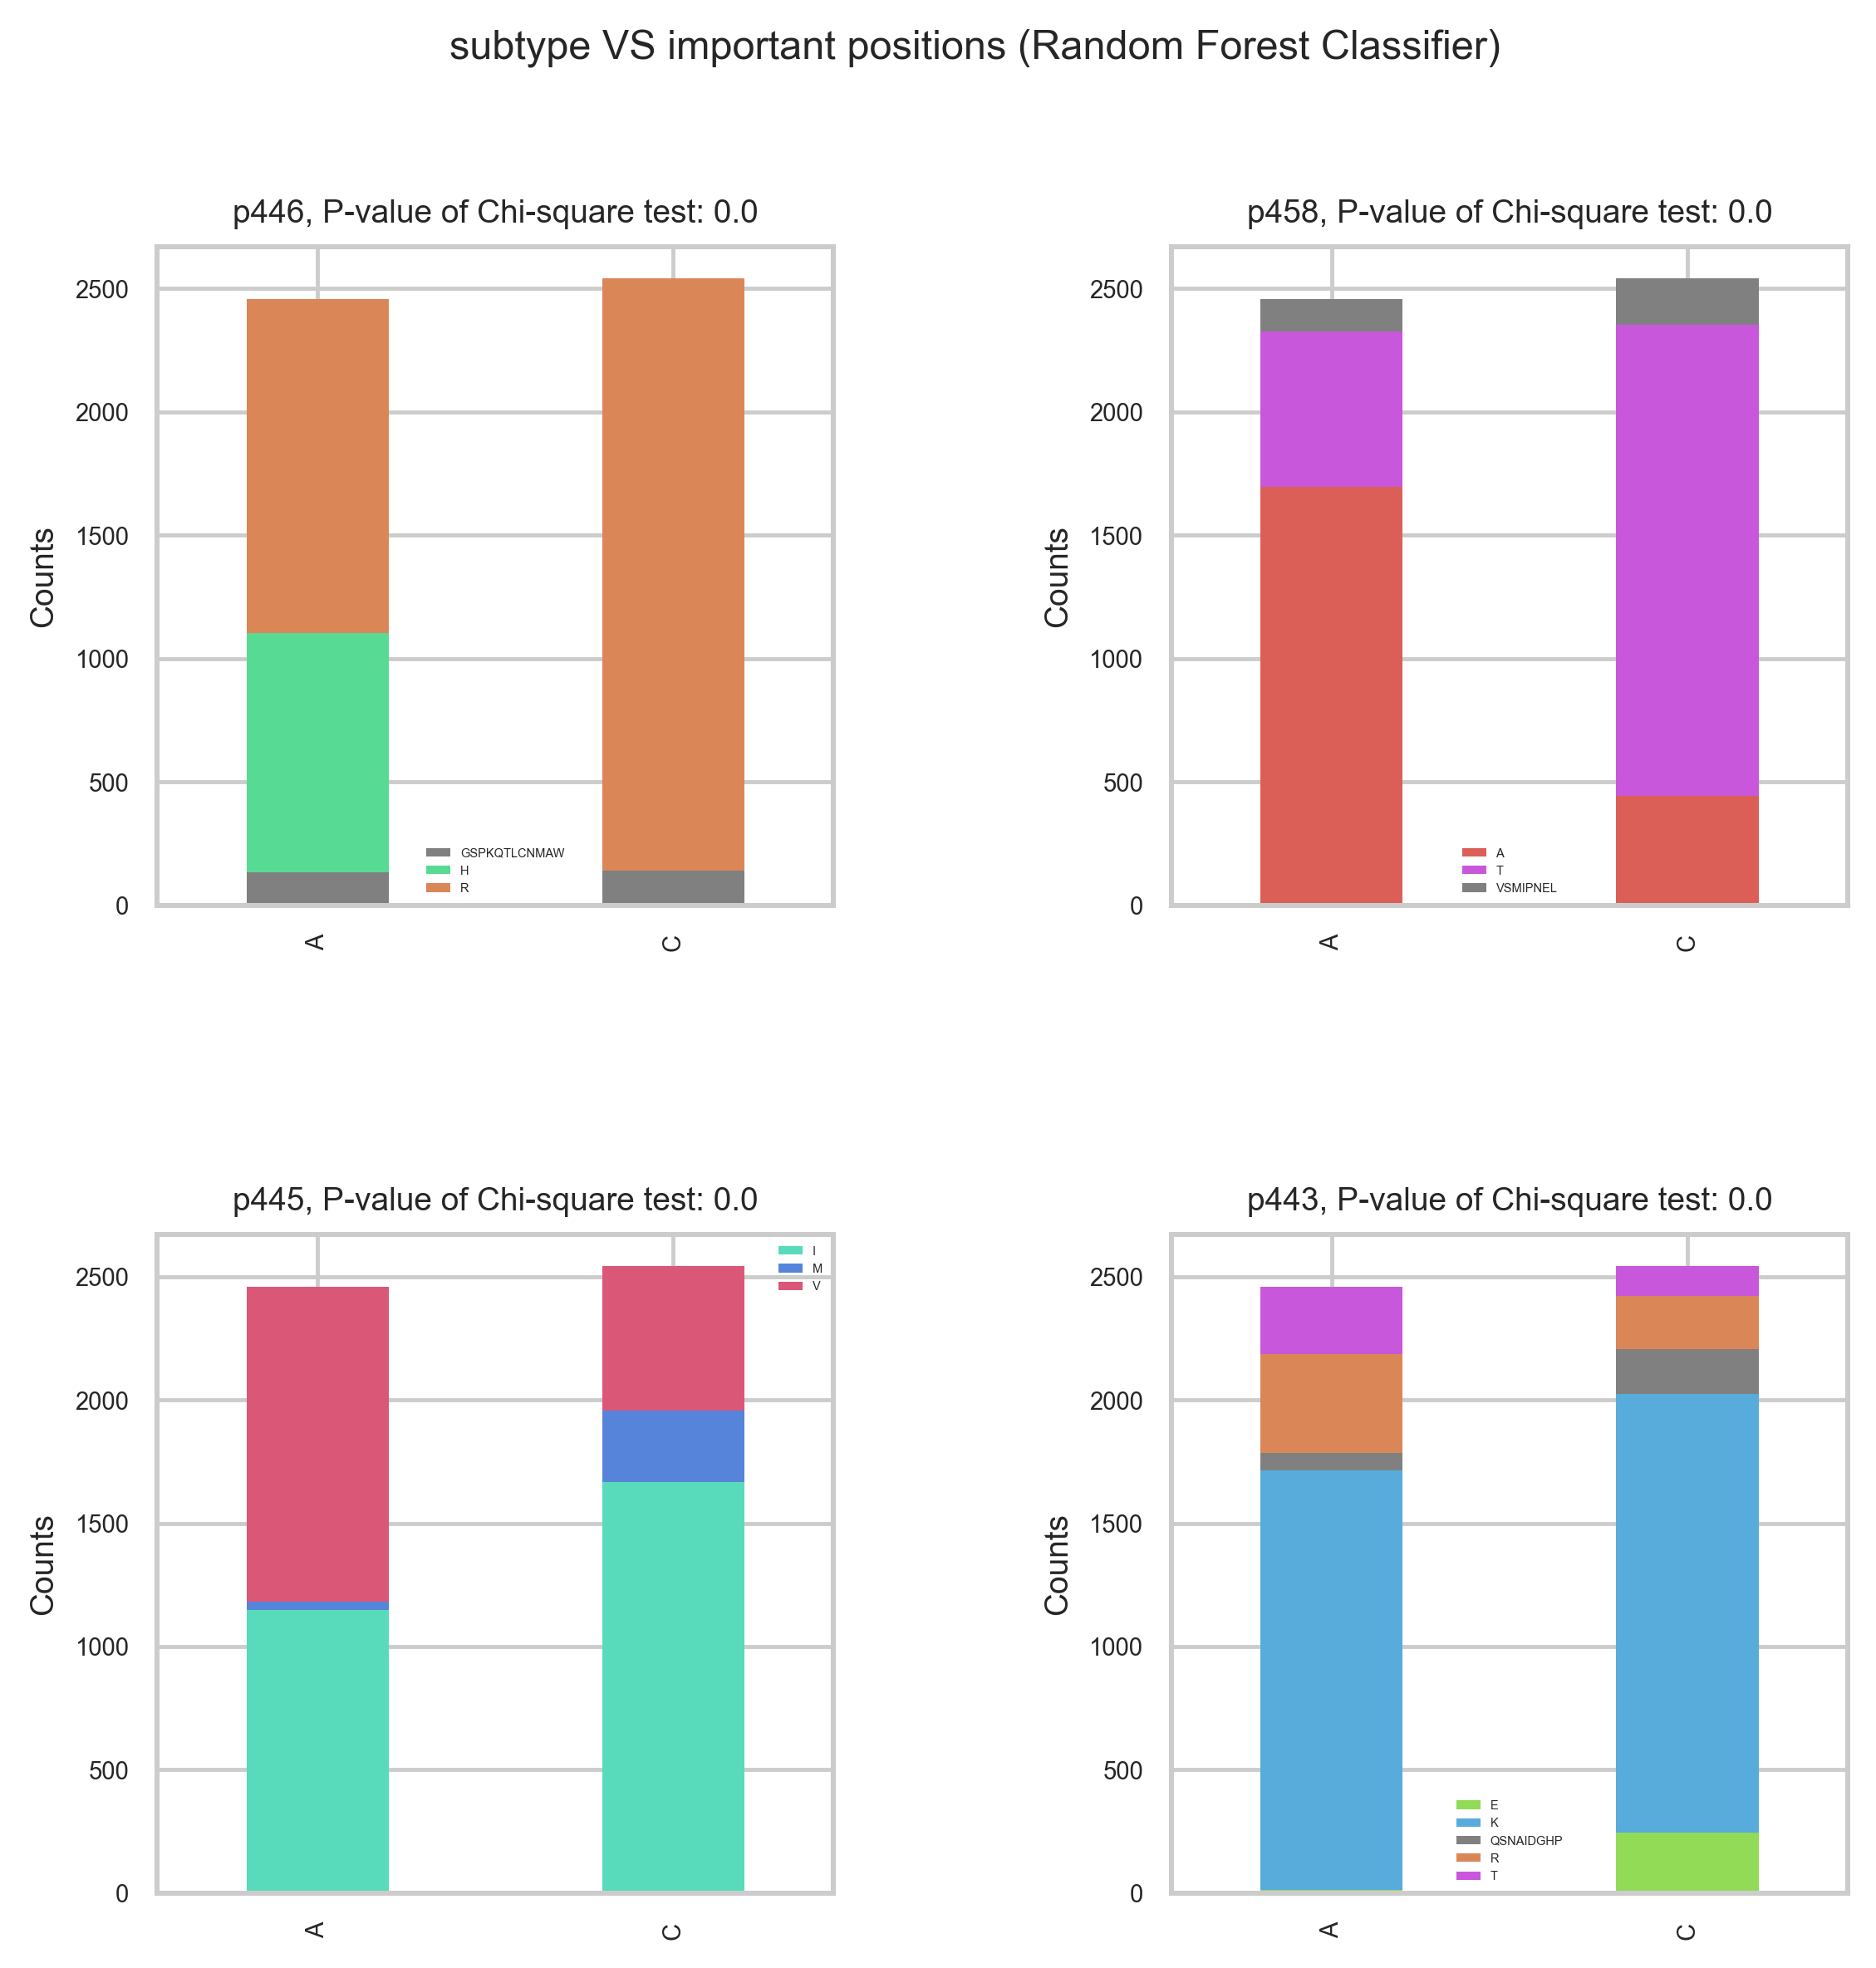

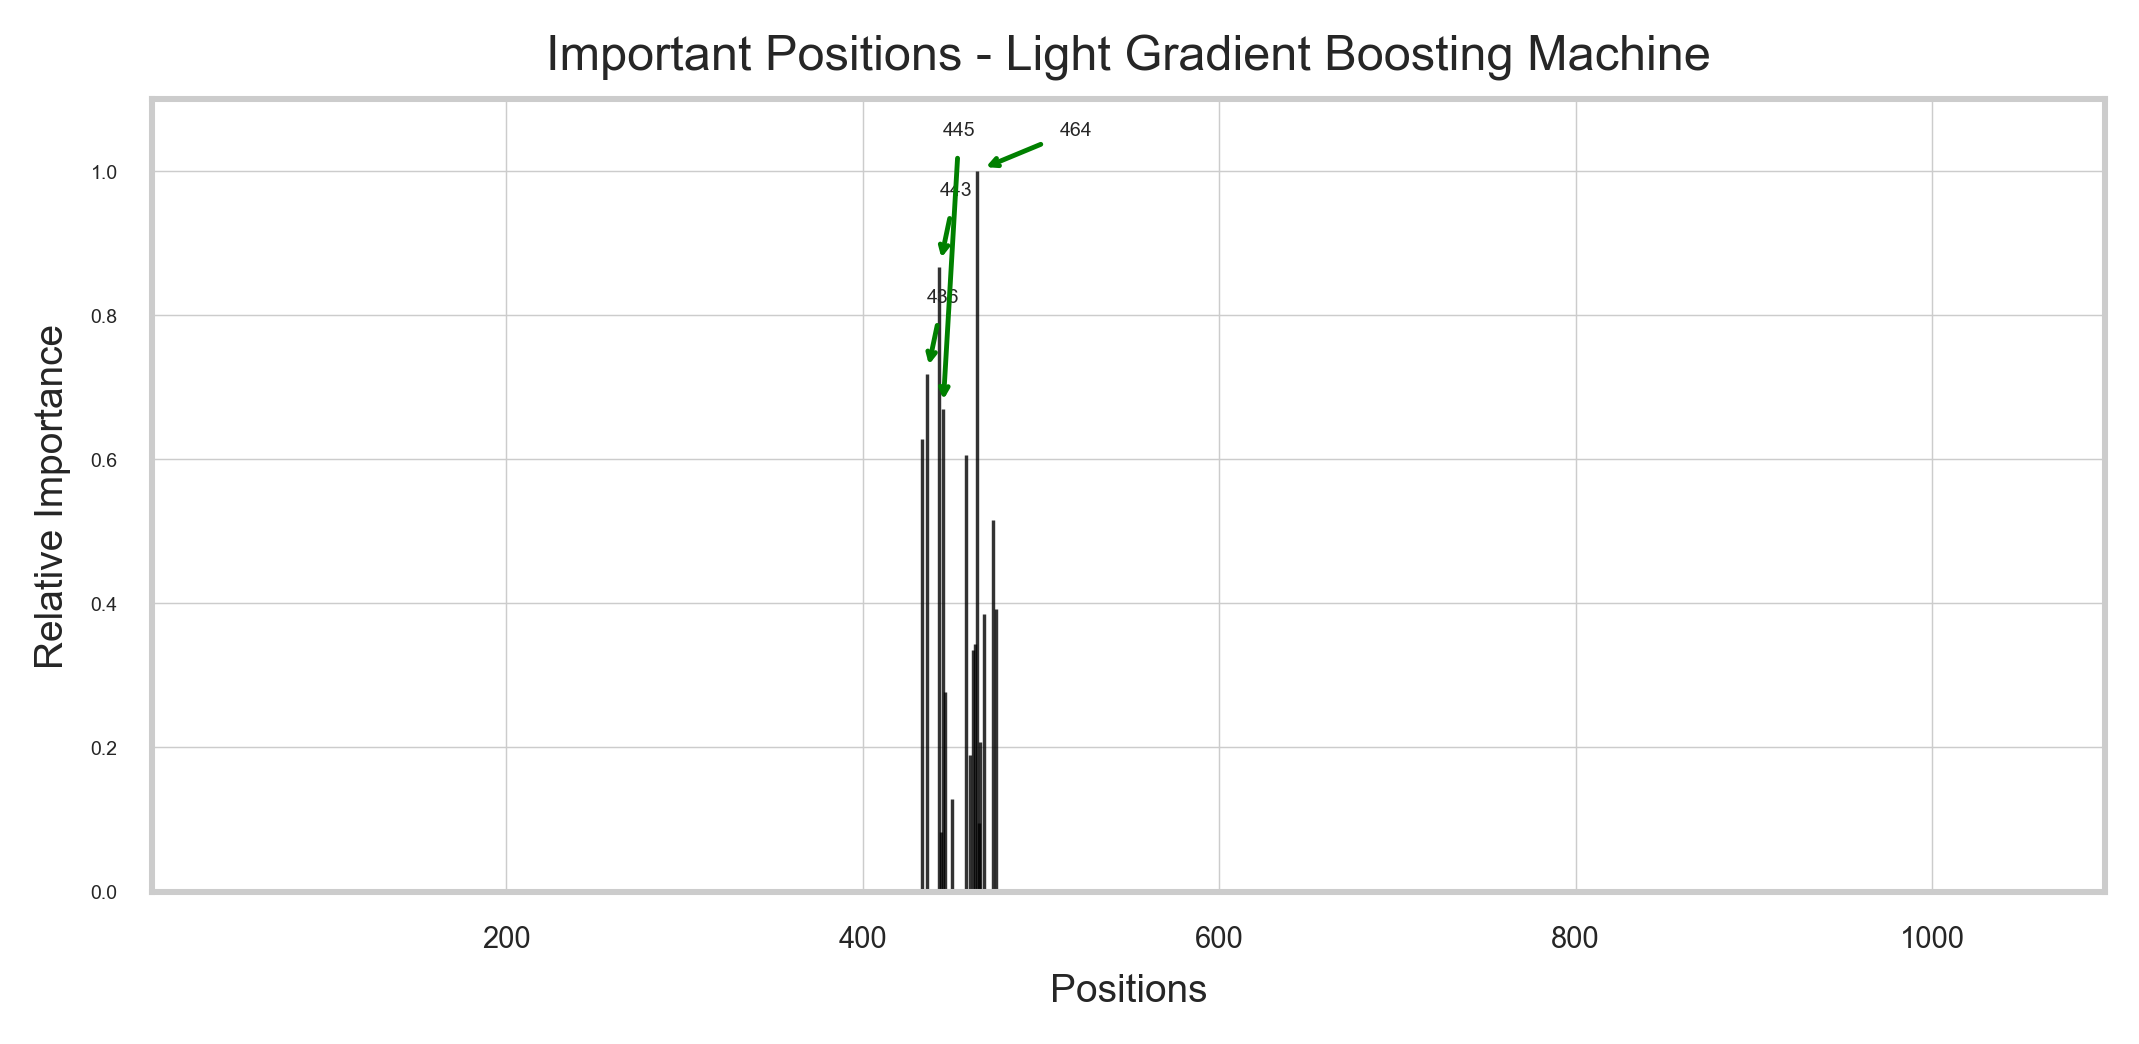

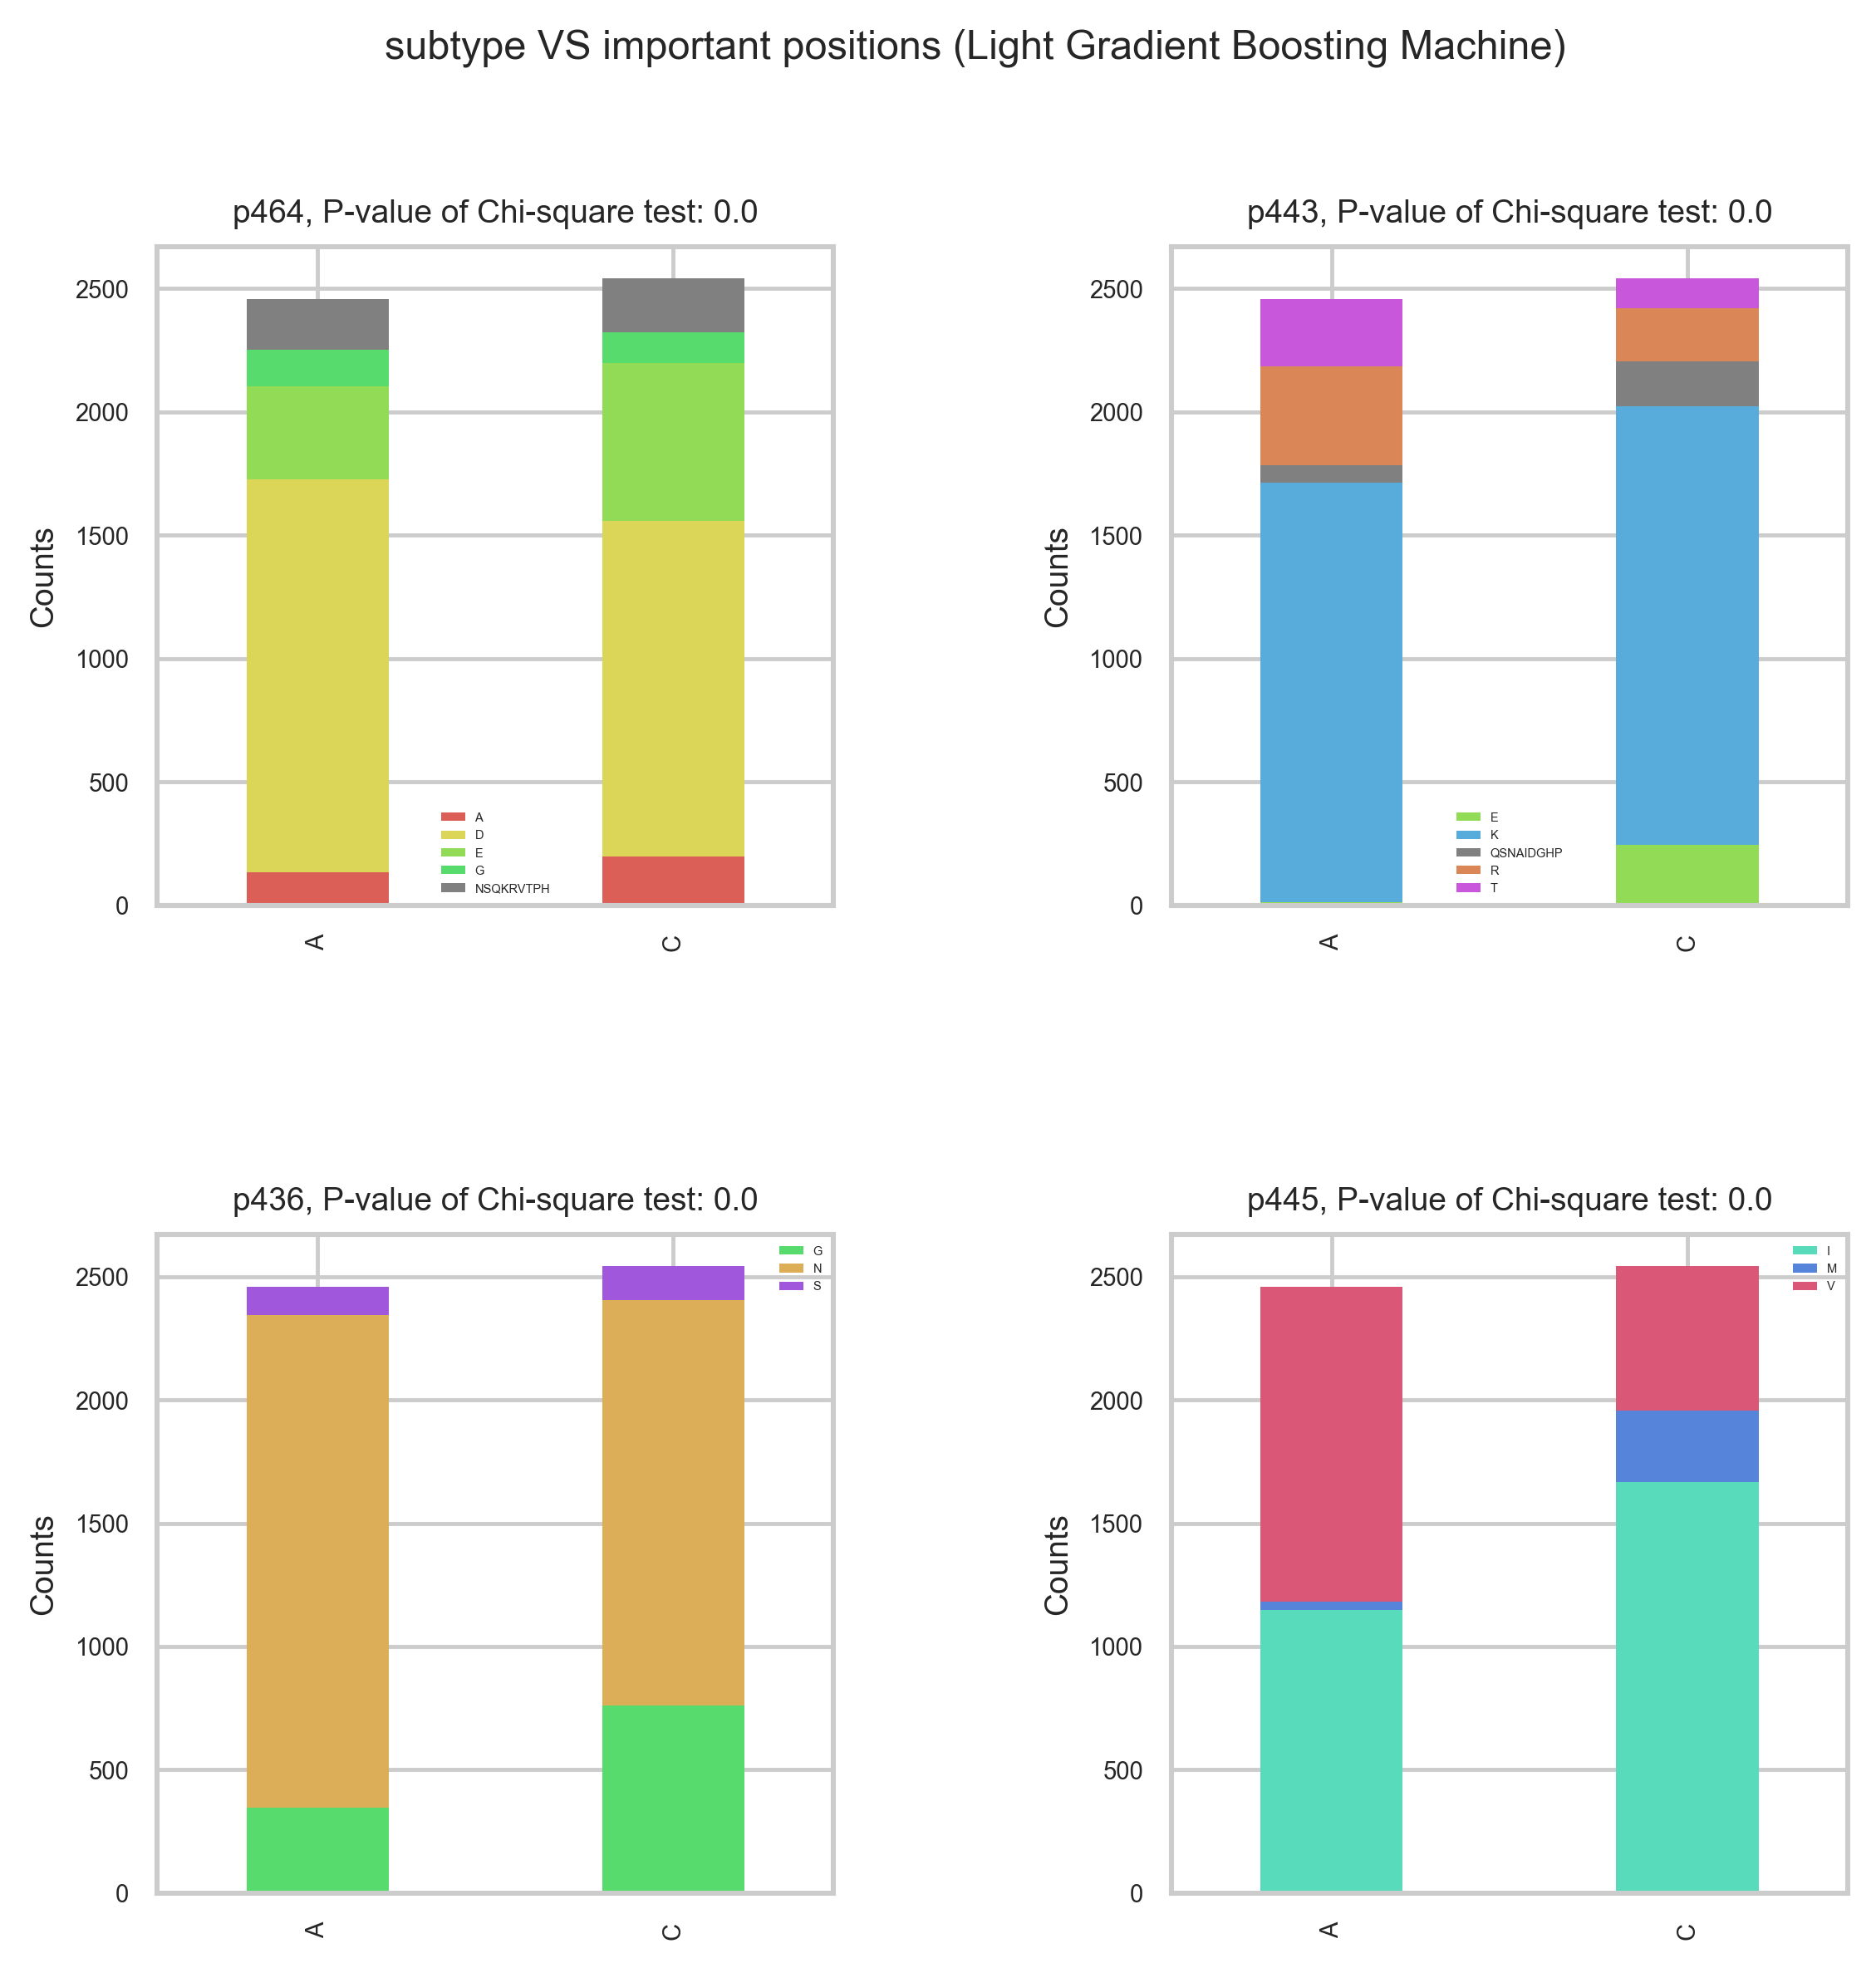

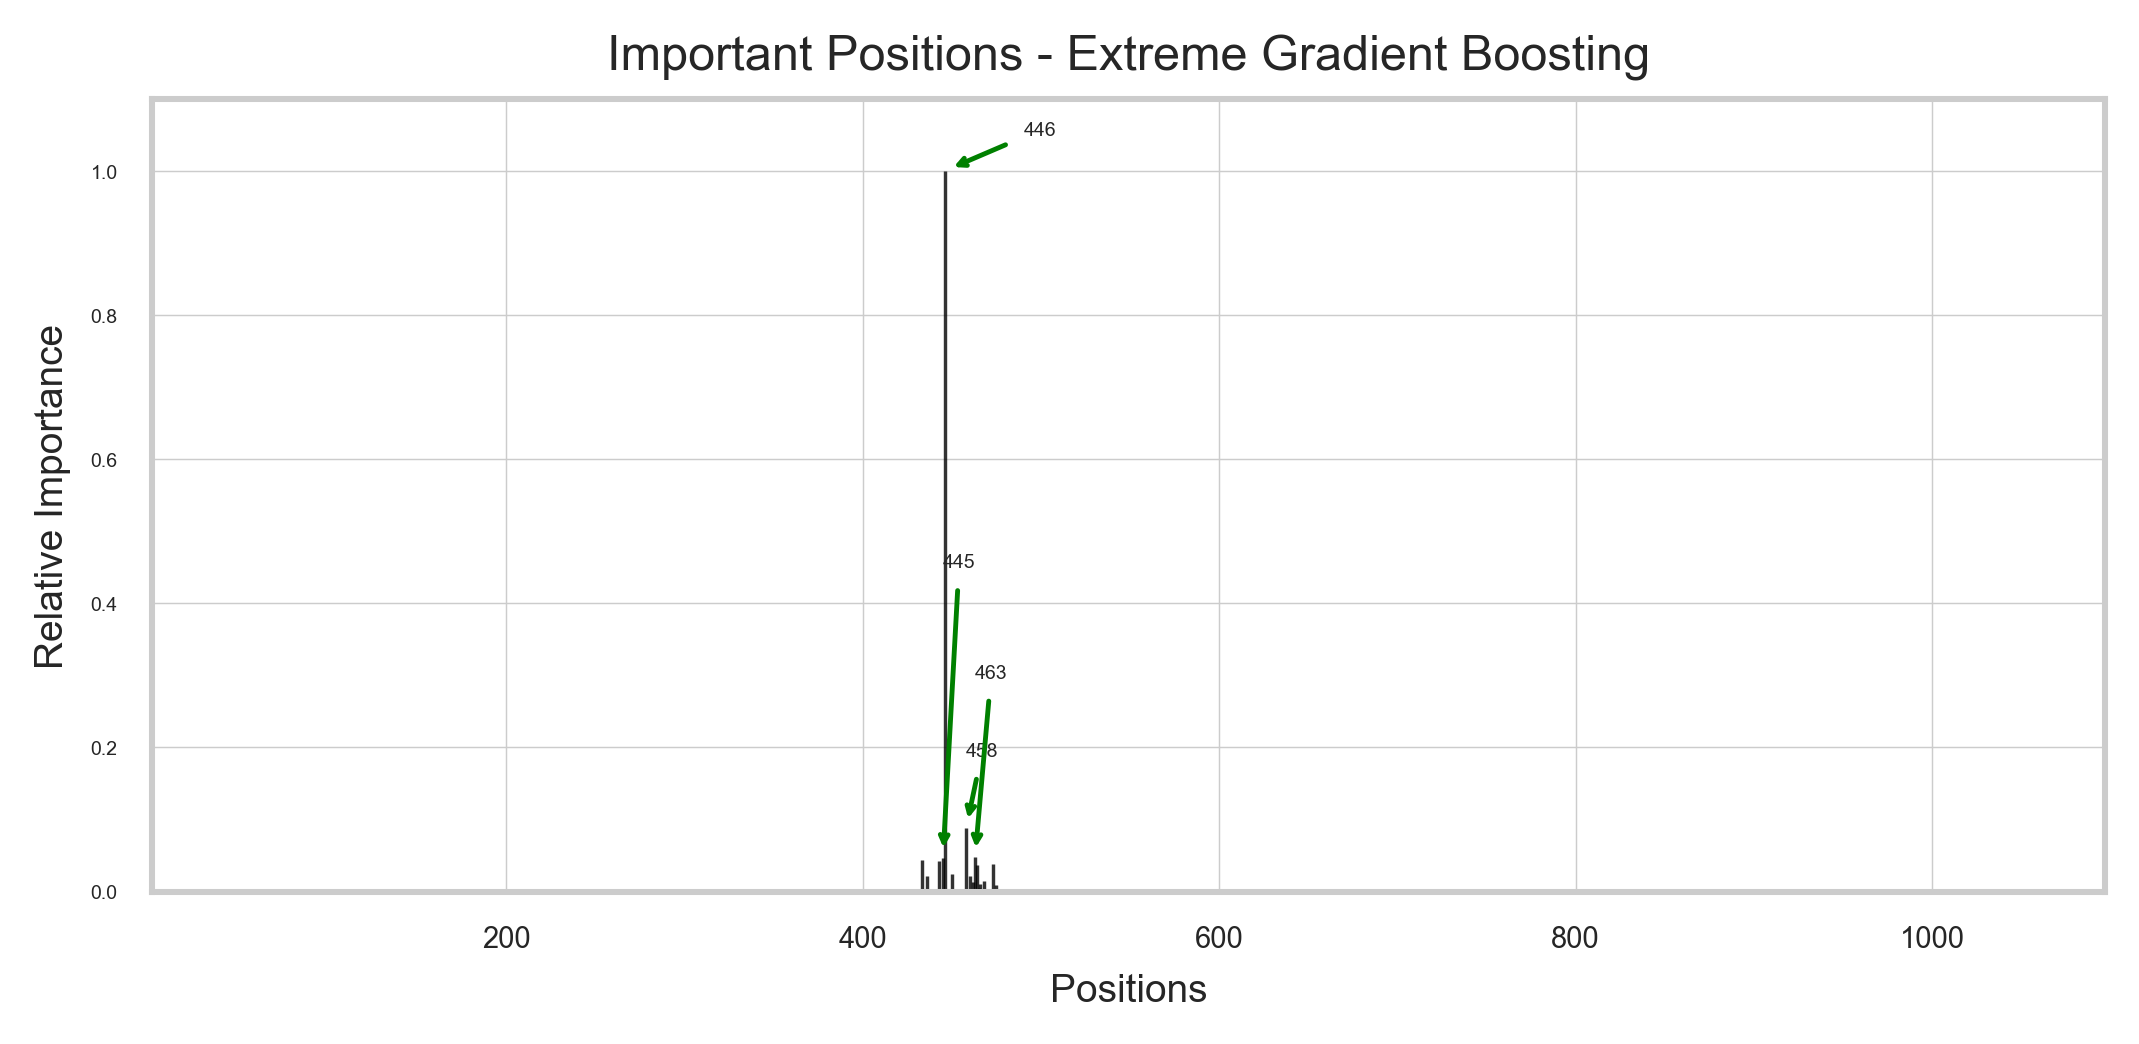

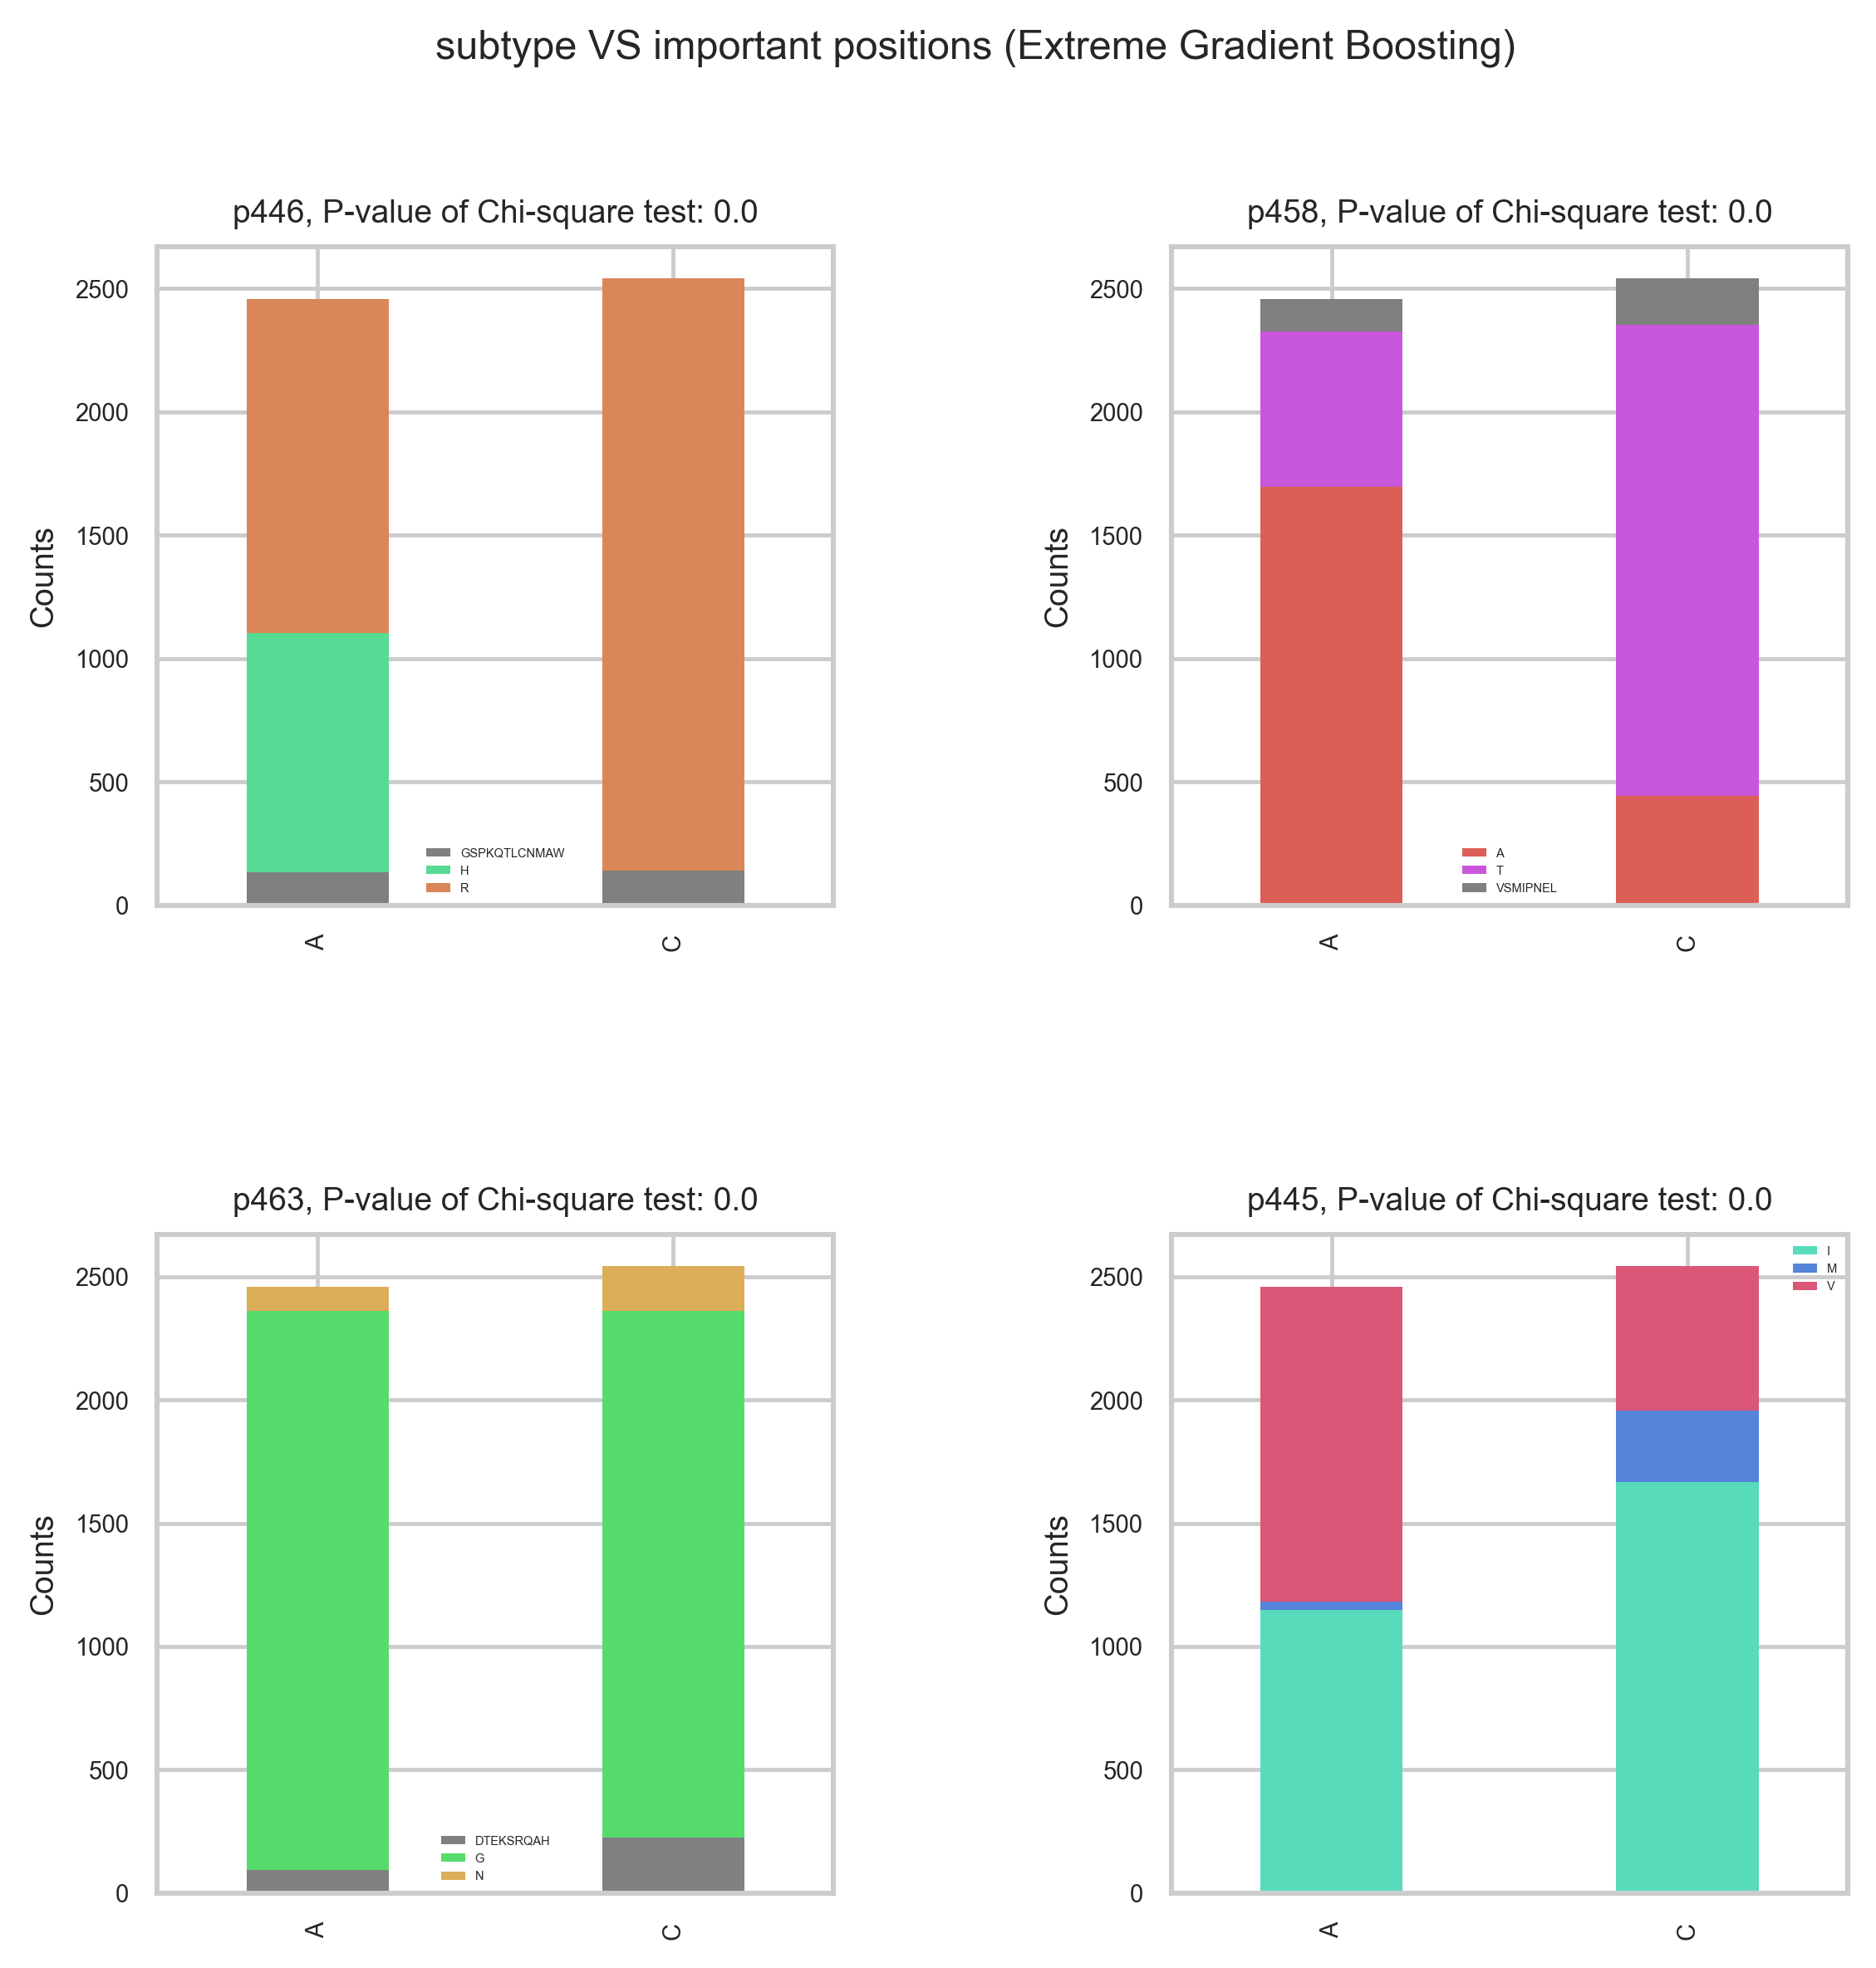

In [23]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

/Users/mbagh/Documents/RahLab/deepBreaks_data/HIV/HIV-1_env_subtype_2022-11-04_14-14-15/mean_350.png


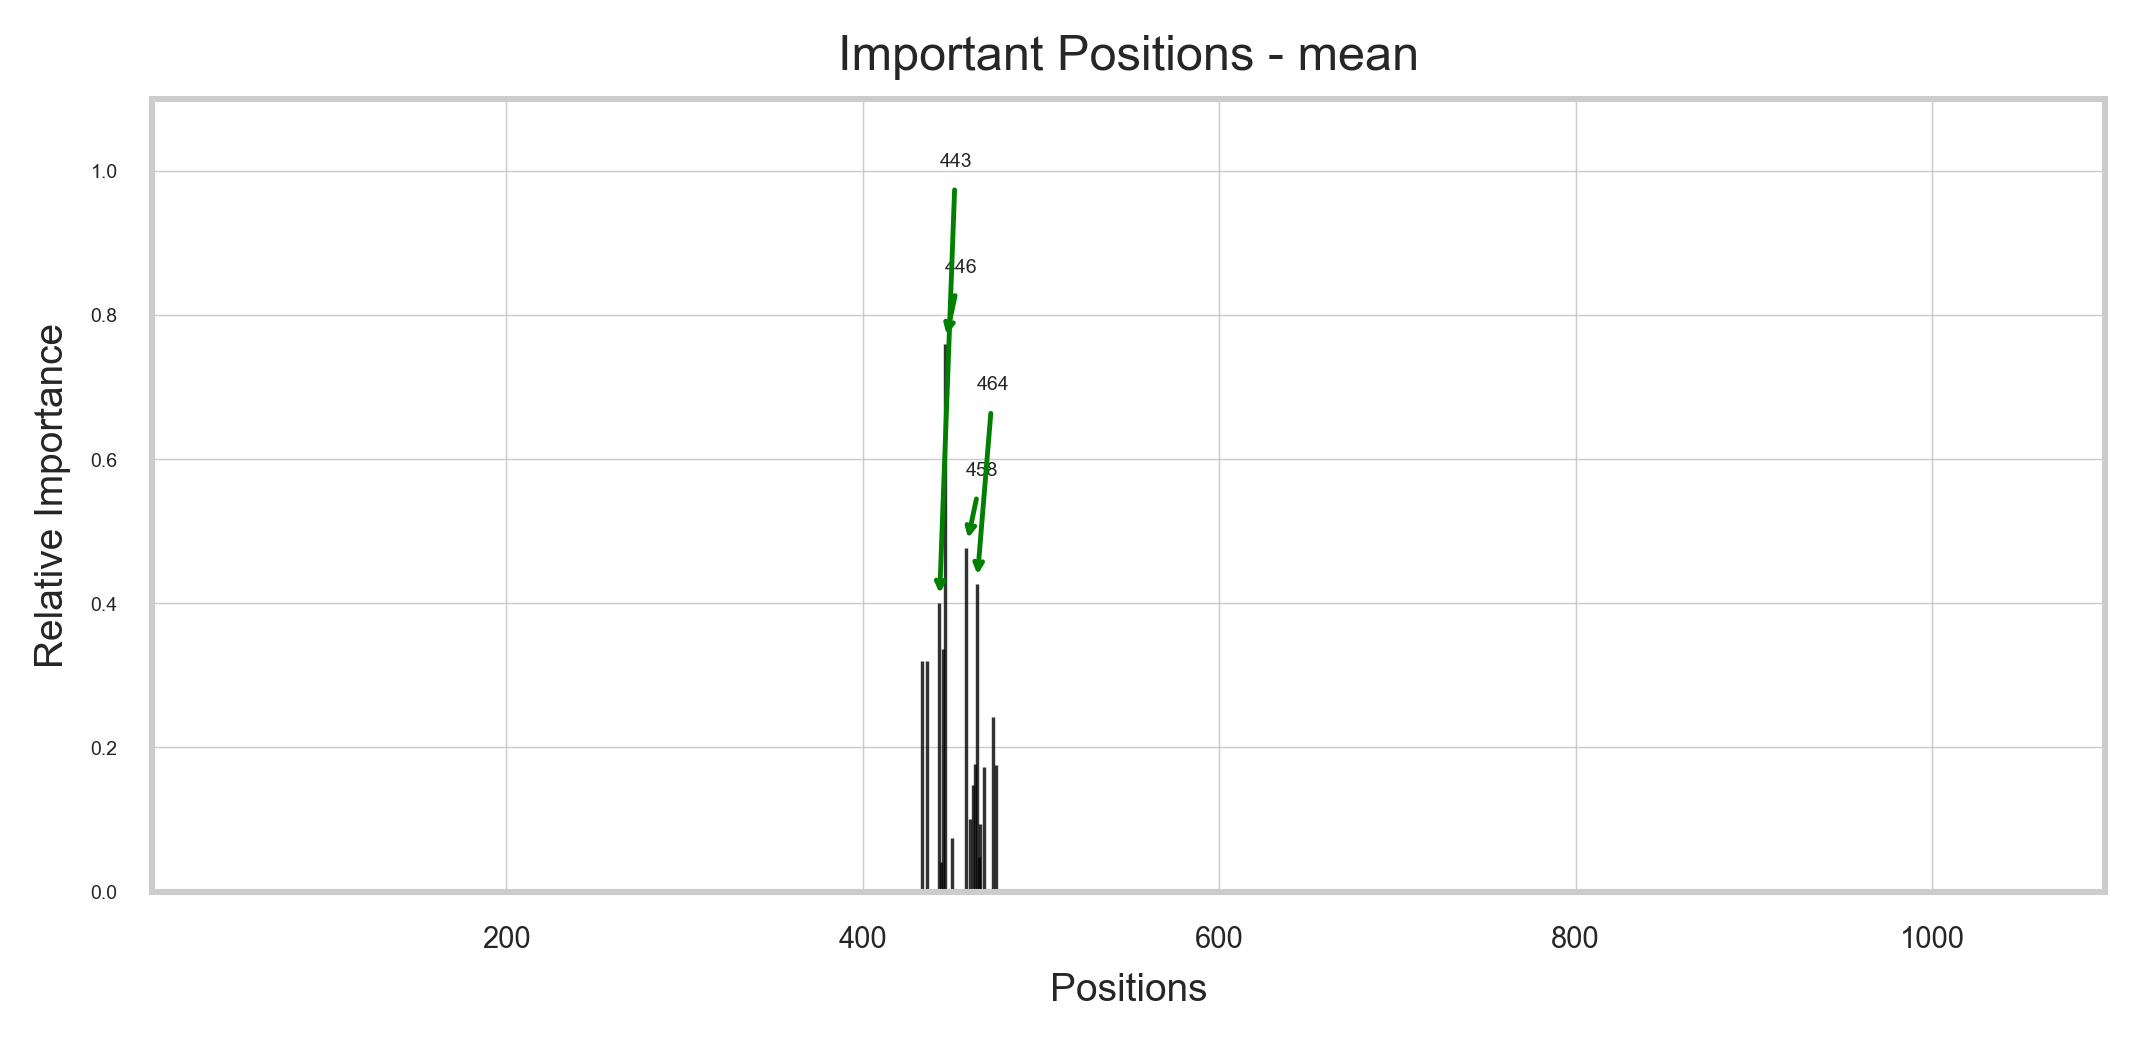

In [24]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,
            model_name= 'mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

<span style="color:red">**Running the next cell will produce individual plots for all of the positions in you sequence.**</span>

In [26]:
# visualizing top positions 
# viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
#                  grouped_features=dc, meta_var=mt, model_type=anaType,
#                  n_positions=positions, report_dir=report_dir)